### ANÁLISE E PREVISÃO DA ARRECADAÇÃO FEDERAL

Autor: GABRIEL RODRIGUES  MARCOLINI

In [1]:
#pip install pmdarima

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [3]:
#Define parâmetros iniciais
dataset_path = '.\\dataset\\CSV\\'
filename_input = 'arrecadacao-TOTAL-GERAL-2015-2020.csv'
indicadores = 'xgdvConsulta.csv'

In [4]:
#Faz a leitura dos datasets
#tb = tabela de Arrecadação Federal
#ie = tabela de indicadores econômicos
tb = pd.read_csv(dataset_path+filename_input) 
ie = pd.read_csv(dataset_path+indicadores,sep=';',decimal=',')

In [5]:
#Ajusta o campo DATA do dataframe ie
ie['DATA'] =  pd.to_datetime(ie['DATA'],format="%m/%Y") + pd.tseries.offsets.MonthEnd(0)

In [6]:
#Ajusta o campo DATA do dataframe tb
tb['DATA'] = pd.to_datetime(tb['DATA'],format="%Y/%m/%d")

In [7]:
#Unindo os dataframes tb + ie
left = tb.groupby([tb['DATA']]).sum()
right = ie
result = pd.merge(left,right,how='inner',on='DATA')

In [8]:
# Criando um novo DF para tratar os desvios de arrecadação (outliers) observados em 10/2016 e 04, 05 e 06/2020.
# Os valores serão substitudo pelo valor arrecadado no mesmo mês do ano anterior. 
#outliers = ['2016-10-31','2020-04-30','2020-05-31','2020-06-30']

result_n = result.copy()

result_n.loc[(result_n['DATA'] == '2016-10-31'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2015-10-31'),'VALOR'].values
result_n.loc[(result_n['DATA'] == '2020-04-30'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2019-04-30'),'VALOR'].values
result_n.loc[(result_n['DATA'] == '2020-05-31'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2019-05-31'),'VALOR'].values
result_n.loc[(result_n['DATA'] == '2020-06-30'),'VALOR'] = result_n.loc[(result_n['DATA'] == '2019-06-30'),'VALOR'].values

In [9]:
#Define função para calcular o MAPE - Mean Absolute Percentage Error
def mape(y_pred,y_true):

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
# Ajustar parâmetros de plotagem
#plt.rcParams.keys()
plt.rcParams["text.color"] = 'Blue'
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["figure.figsize"] = [15, 6]
plt.rcParams["lines.linewidth"] = 2.0

In [11]:
# Definindo o DataFrame a ser analisado
df_real = result.groupby([result['DATA']]).sum()['VALOR']
df_normal = result_n.groupby([result_n['DATA']]).sum()['VALOR']
df = df_normal

## Modelo AUTO-ARIMA

In [12]:
import pmdarima as pm

In [13]:
# Separa os dados em treino e teste
train, test = df[0:-18], df[-18:]

In [14]:
#Ajusta o modelo com base nos dados de treino
model_auto = pm.auto_arima(train, m=12, stationarity=False, seasonal=True, stepwise=False,
                           supress_warnings=True, error_action='ignore')
model_auto.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 1, 0, 12),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=False)

In [15]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -834.955
Date:                            Sun, 30 Aug 2020   AIC                           1671.910
Time:                                    17:47:30   BIC                           1673.465
Sample:                                         0   HQIC                          1672.447
                                             - 48                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.124e+19   3.45e+18      6.161      0.000    1.45e+19     2.8e+19
===================================================================================
Ljung-Box (Q):                       40.11   Jarque-Bera (JB):                 0.16
Prob(Q):                              0.22   Prob(JB):                         0.92
Heteroskedasticity (H):               4.51   Skew:                             0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
#Faz a previsão no mesmo tamanho que a base de teste
yhat = model_auto.predict(n_periods=len(test))
yhat = pd.Series(yhat, index = test.index)
#Obtém o intervalo de confiança 
conf_int = model_auto.predict(len(test), return_conf_int=True, alpha = 0.05) 

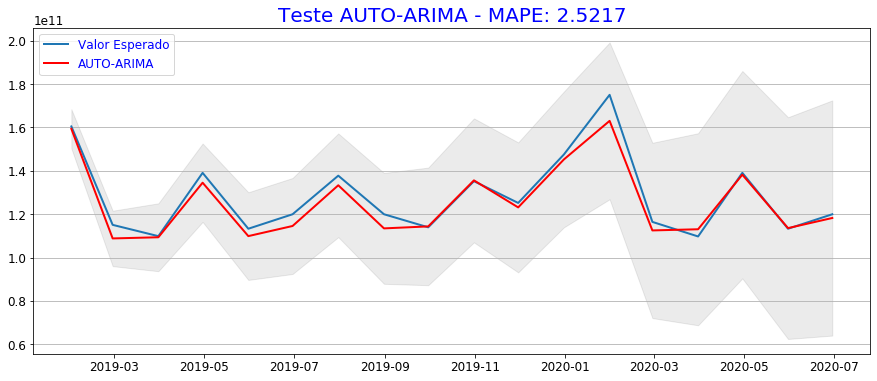

In [17]:
#Plota o resultado do modelo
plt.plot(test, label='Valor Esperado')
plt.plot(yhat, color='red', label='AUTO-ARIMA')
plt.fill_between(test.index, conf_int[1][:,0], conf_int[1][:,1], color='k', alpha=.08)
plt.title('Teste AUTO-ARIMA - MAPE: %.4f' % mape(yhat,test))
plt.grid(True,axis='y')
plt.legend(loc='upper left')

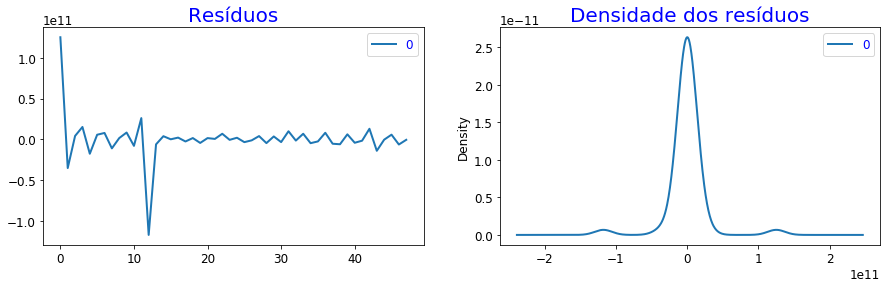

In [18]:
#Plotagem dos resíduos e densidade dos resíduos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
residuals = pd.DataFrame(model_auto.resid())
residuals.plot(ax=ax1, title='Resíduos', label=None)
residuals.plot(ax=ax2,kind='kde', title='Densidade dos resíduos')
plt.show()

[]

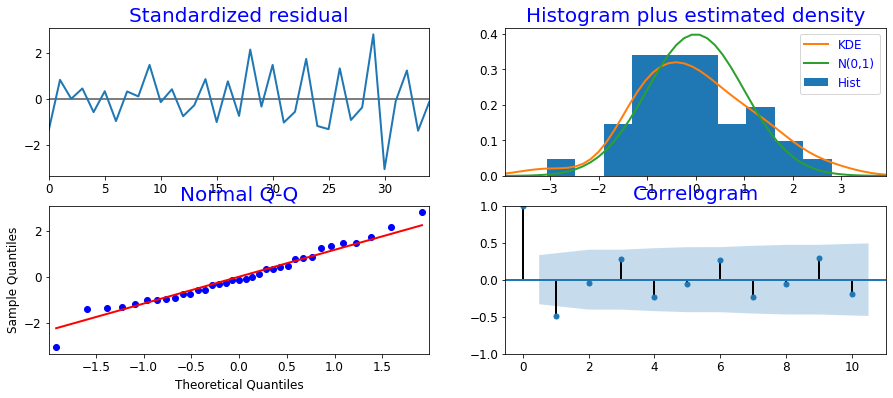

In [19]:
#Plota o diagnóstico do modelo 
model_auto.plot_diagnostics()
plt.plot()

## Realizando uma projeção AUTO-ARIMA utilizando os Valores Normais de arrecadação

In [20]:
# Define a base de treino considerando o dataset contendo os valores normais da arrecadação. 
train = df_normal

In [21]:
#Ajusta o modelo com base nos dados de treino
model_auto = pm.auto_arima(train, m=12, stationarity=False, seasonal=True, stepwise=False,
                           supress_warnings=True, error_action='ignore')
model_auto.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 1, 2, 12),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [23]:
#Faz a previsão do tamanho de 'nper'
nper=24
yhat = model_auto.predict(n_periods=nper)
date_range = pd.date_range(start='2020-07-31', periods=nper, freq='M')
yhat = pd.Series(yhat, index = date_range)
#Calcula a média móvel
mov_avg = train.append(yhat)
mov_avg = mov_avg.rolling(window=12).mean()
#Acrescenta o ponto de junção 
yhat = yhat.append(train.last('m'))
yhat.sort_index(inplace=True)
#Obtém o intervalo de confiança 
conf_int = model_auto.predict(nper, return_conf_int=True, alpha = 0.05) 

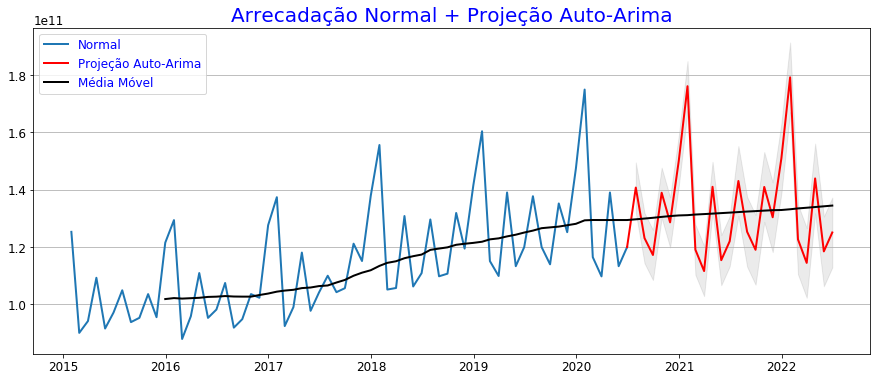

In [24]:
#Plota o resultado da projeção
plt.title('Arrecadação Normal + Projeção Auto-Arima')
plt.plot(train, label='Normal')
plt.plot(yhat, color='red', label='Projeção Auto-Arima')
plt.fill_between(yhat.index[-nper:], conf_int[1][:,0], conf_int[1][:,1], color='k', alpha=.08)
plt.plot(mov_avg, color='black', label='Média Móvel')
plt.grid(True,axis='y')
plt.legend(loc='upper left')
plt.show()

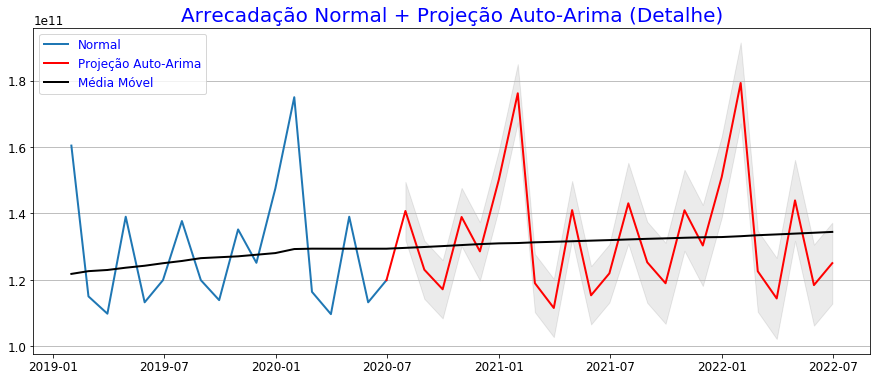

In [25]:
#Plota o resultado da projeção (Detalhe)
plt.title('Arrecadação Normal + Projeção Auto-Arima (Detalhe)')
plt.plot(train[-18:], label='Normal')
plt.plot(yhat, color='red', label='Projeção Auto-Arima')
plt.fill_between(yhat.index[-nper:], conf_int[1][:,0], conf_int[1][:,1], color='k', alpha=.08)
plt.plot(mov_avg[-nper-18:], color='black', label='Média Móvel')
plt.grid(True,axis='y')
plt.legend(loc='upper left')
plt.show()

## Realizando uma previsão AUTO-ARIMA utilizando os Valores REAIS de arrecadação

In [26]:
# Define a base de treino considerando o dataset contendo os valores reais da arrecadação. 
train = df_real

In [27]:
#Ajusta o modelo com base nos dados de treino
model_auto = pm.auto_arima(train, m=12, stationarity=False, seasonal=True, stepwise=False,
                           supress_warnings=True, error_action='ignore')
model_auto.fit(train)

ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 1, 0, 12),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [28]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   66
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood               -1331.462
Date:                             Sun, 30 Aug 2020   AIC                           2668.924
Time:                                     17:49:22   BIC                           2674.891
Sample:                                          0   HQIC                          2671.225
                                              - 66                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.919e+09   4.65e-13   8.43e+21      0.000    3.92e+09    3.92e+09
ma.L1          0.1767      0.066      2.674      0.007       0.047       0.306
sigma2      1.564e+20   5.34e-23   2.93e+42      0.000    1.56e+20    1.56e+20
===================================================================================
Ljung-Box (Q):                       27.56   Jarque-Bera (JB):                51.59
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.83   Skew:                            -0.85
Prob(H) (two-sided):                  0.21   Kurtosis:                         7.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.58e+57. Standard errors may be unstable.
"""

In [29]:
#Faz a previsão do tamanho de 'nper'
nper=24
yhat = model_auto.predict(n_periods=nper)
date_range = pd.date_range(start='2020-07-31', periods=nper, freq='M')
yhat = pd.Series(yhat, index = date_range)
#Calcula a média móvel
mov_avg = train.append(yhat)
mov_avg = mov_avg.rolling(window=12).mean()
#Acrescenta o ponto de junção 
yhat = yhat.append(train.last('m'))
yhat.sort_index(inplace=True)
#Obtém o intervalo de confiança 
conf_int = model_auto.predict(nper, return_conf_int=True, alpha = 0.05) 

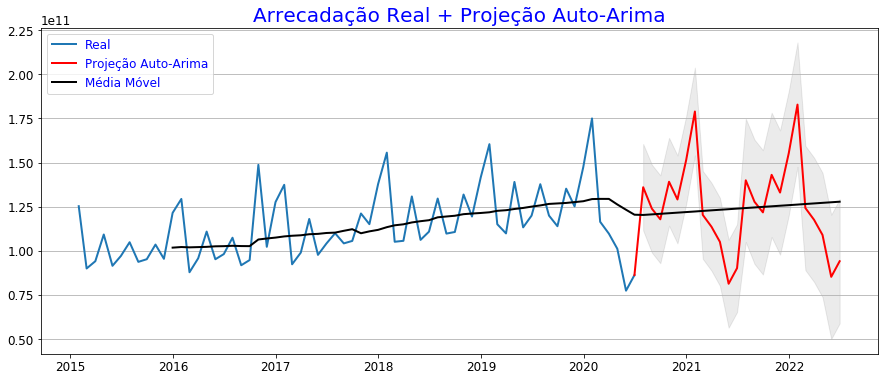

In [30]:
#Plota o resultado da projeção
plt.title('Arrecadação Real + Projeção Auto-Arima')
plt.plot(train, label='Real')
plt.plot(yhat, color='red', label='Projeção Auto-Arima')
plt.fill_between(yhat.index[-nper:], conf_int[1][:,0], conf_int[1][:,1], color='k', alpha=.08)
plt.plot(mov_avg, color='black', label='Média Móvel')
plt.grid(True,axis='y')
plt.legend(loc='upper left')
plt.show()

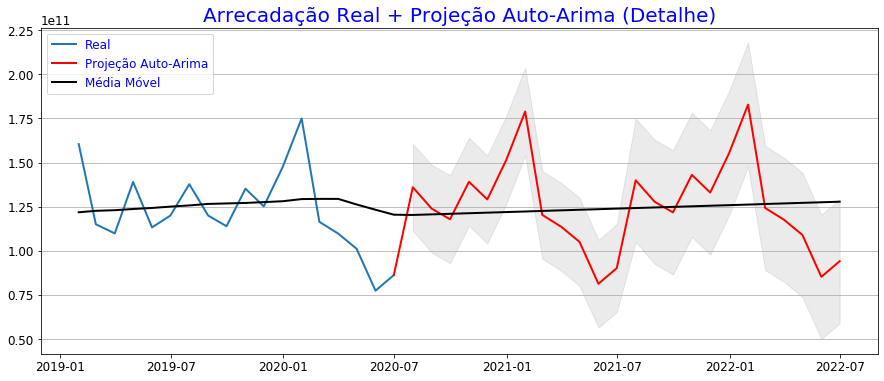

In [31]:
#Plota o resultado da projeção (Detalhe)
plt.title('Arrecadação Real + Projeção Auto-Arima (Detalhe)')
plt.plot(train[-18:], label='Real')
plt.plot(yhat, color='red', label='Projeção Auto-Arima')
plt.fill_between(yhat.index[-nper:], conf_int[1][:,0], conf_int[1][:,1], color='k', alpha=.08)
plt.plot(mov_avg[-nper-18:], color='black', label='Média Móvel')
plt.grid(True,axis='y')
plt.legend(loc='upper left')
plt.show()